# Stock Price Modeling from Fundamentals

In [56]:
# Todo :
# - Create labels from stock price data before and after earnings. 
#   This should correlate the change in stock price with the change in fundamentals
# - Create validation and test sets
#   4th most recent quarter's price for validation.
#   3 most recent quarters' price for test
# - Start modeling. Try some baselines first (e.g. mean estimates, repeating previous periods)
#   Try some additional models (e.g. ARIMA, XGBoost trees)

In [57]:
from pathlib import Path
import pandas as pd

prices = pd.read_csv(Path("preprocessed") / "KMB_prices_dates.csv")
financials = pd.read_csv(Path("preprocessed") / "KMB_financials.csv")

prices.shape, financials.shape

((6282, 6), (448, 319))

In [58]:
prices["target"] = prices["Close"] - prices["Open"]
prices = prices[["Date", "target"]] # backward looking
priced = prices.sort_values(by="Date")
prices.head(3)

,Date,target
0,2001-02-22,0.083130
1,2001-02-23,-0.062352
2,2001-02-26,0.257708


In [59]:
financials["period_end"] = financials["period_end"]
financials.head(3)

,period_end,filing_date,form,AccountsPayableCurrent,AccountsPayableTradeCurrent,AccountsReceivableNetCurrent,AccruedAdvertisingCurrent,AccruedIncomeTaxesNoncurrent,AccruedLiabilitiesCurrent,AccruedSalariesCurrent,...,UnrecordedUnconditionalPurchaseObligationBalanceOnThirdAnniversary,UnrecordedUnconditionalPurchaseObligationDueAfterFiveYears,VariableLeaseCost,WeightedAverageNumberOfDilutedSharesOutstanding,WeightedAverageNumberOfSharesIssuedBasic,WeightedAverageNumberOfSharesOutstandingBasic,0,1,2,3
0,2006-12-31,2010-02-24,10-K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1,2007-12-31,2009-08-07,10-Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,2007-12-31,2009-11-06,10-Q/A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0


In [60]:
dates = pd.read_csv(Path("preprocessed") / "KMB_dates.csv")
dates.head(3)

,filing_date,report_date
0,2026-02-12,2025-12-31
1,2026-02-10,2026-02-09
2,2026-02-09,2025-03-31


# Setup

In [61]:
merged = prices.merge(financials, left_on="Date", right_on="period_end").sort_values(by="period_end")
merged = merged.merge(dates, left_on="Date", right_on="report_date", suffixes=("", "_drop"))
merged = merged.drop(columns=["Date", "filing_date_drop", "report_date"])
financial_cols = list(set(merged.columns) - {'0', '1', '2', '3', 'filing_date', 'form'})
binarized_form_cols = ['0', '1', '2', '3']
grouped = merged.groupby('period_end')

agg_logic = {col: 'first' for col in financial_cols}
form_logic = {col: 'max' for col in binarized_form_cols}

df_consolidated = grouped.agg({**agg_logic, **form_logic})

df_consolidated.head()

,IncreaseDecreaseInAccountsPayableTrade,CurrentIncomeTaxExpenseBenefit,OperatingLeaseCost,EffectiveIncomeTaxRateReconciliationChangeInDeferredTaxAssetsValuationAllowance,CommonStockDividendsPerShareCashPaid,CommonStockDividendsPerShareDeclared,AmortizationOfIntangibleAssets,Assets,EquityMethodInvestmentSummarizedFinancialInformationNetIncomeLoss,InventoryFinishedGoods,...,NonoperatingIncomeExpense,AdditionalPaidInCapital,DeferredTaxLiabilitiesGoodwillAndIntangibleAssetsGoodwill,PreferredStockParOrStatedValuePerShare,OtherComprehensiveIncomeLossCashFlowHedgeGainLossBeforeReclassificationAndTax,IncrementalCommonSharesAttributableToShareBasedPaymentArrangements,0,1,2,3
period_end,,,,,,,,,,,,,,,,,,,,,
2016-09-30,NaN,NaN,NaN,NaN,NaN,1.840,NaN,1.489900e+10,NaN,1.074000e+09,...,NaN,NaN,NaN,NaN,NaN,2350000.0,0,1,0,0
2017-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2017-03-31,NaN,NaN,NaN,NaN,NaN,0.970,NaN,1.475800e+10,NaN,1.064000e+09,...,-14000000.0,NaN,NaN,NaN,NaN,2600000.0,0,1,0,0
2017-06-30,NaN,NaN,NaN,NaN,NaN,1.455,NaN,1.507000e+10,NaN,1.072000e+09,...,-22000000.0,NaN,NaN,NaN,NaN,2350000.0,1,1,0,0
2018-12-31,392000000.0,469000000.0,NaN,0.016,NaN,NaN,NaN,1.451800e+10,215000000.0,1.153000e+09,...,-163000000.0,548000000.0,72000000.0,0.0,NaN,1600000.0,1,1,0,0


In [62]:
# def coord_to_date(year, fractional_day):
#     day_of_year = int(fractional_day * 366)
#     return pd.to_datetime(year, format='%Y') + pd.Timedelta(days=day_of_year - 1)

# # Apply this to create a real DatetimeIndex
# days.index = [coord_to_date(y, f) for y, f in zip(years, days)]
# days.index

In [63]:
full_calendar = pd.date_range(start=df_consolidated["period_end"].index.min(), end=df_consolidated["period_end"].index.max(), freq='B')
daily = df_consolidated.reindex(full_calendar)
daily = daily.ffill()
daily = daily.drop(columns=["target"]) # construct targets for each day later in the program

daily.shape

C:\Users\seani\AppData\Local\Temp\ipykernel_49428\3332026667.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily = daily.ffill()


(2414, 317)

In [64]:
y = pd.read_csv(Path("preprocessed") / "KMB_prices_dates.csv").set_index("Date")
y = y.set_index(pd.to_datetime(y.index))
y_stock_returns = (y["Close"] - y["Open"])
y_stock_returns = y_stock_returns.loc[daily.index.min():daily.index.max()]

y_stock_returns = y_stock_returns.asfreq("B")
daily = daily.loc[y_stock_returns.index]
print(y_stock_returns.shape, daily.shape)
y_stock_returns.head(3)

(2414,) (2414, 317)


Date
2016-09-30    0.312489
2016-10-03   -0.552301
2016-10-04   -1.489774
Freq: B, dtype: float64

In [65]:
holidays = y_stock_returns.isna()

daily = daily.loc[~holidays]
y_stock_returns = y_stock_returns.loc[~holidays]

daily.shape, y_stock_returns.shape

((2326, 317), (2326,))

In [66]:
X_train, X_test = daily.iloc[:-180], daily.iloc[-180:]
y_train, y_test = y_stock_returns.iloc[:-180], y_stock_returns.iloc[-180:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2146, 317), (2146,), (180, 317), (180,))

# Prediction Task  
  
Predict the day-of-earnings price movement (i.e. close price minus open price)

## Baseline

In [67]:
mean_pred = y_train.mean()
max_pred = y_train.max()
med_pred = y_train.median()
recent_pred = y_train.iloc[-1]

mean_pred, max_pred, med_pred, recent_pred,

(np.float64(0.01966735905364402),
 np.float64(10.11609381182457),
 np.float64(0.0465931168108753),
 np.float64(2.6460335936180854))

In [68]:
import numpy as np
from sklearn.metrics import root_mean_squared_error as rmse

def print_rmse(actual, pred, loss_for):
    loss = rmse(actual, pred)

    print(f"{loss_for} loss = {loss:.4f}")

def print_full_rmse(const_pred):
    print_rmse(y_train, y_train.apply(lambda x: const_pred), "Training")
    print_rmse(y_test, y_test.apply(lambda x: const_pred), "Test")

In [69]:
print("Mean baseline:")
print_full_rmse(mean_pred)
print()
print("Max baseline:")
print_full_rmse(max_pred)
print()
print("Median baseline:")
print_full_rmse(med_pred)
print()
print("Recent baseline:")
print_full_rmse(recent_pred)
print()

Mean baseline:
Training loss = 1.2403
Test loss = 1.2903

Max baseline:
Training loss = 10.1723
Test loss = 10.3431

Median baseline:
Training loss = 1.2406
Test loss = 1.2940

Recent baseline:
Training loss = 2.9045
Test loss = 3.0726



To contextualize this RMSE, the current stock price is ~$100 so the loss approximately corresponds to the percent error in estimated and actual pricing.  

## SARIMA

In [70]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_zero = pd.DataFrame(X_scaled).fillna(0) # ignored in sparse representation

svd = TruncatedSVD(n_components=25) # avoid high dimensional data by using <= 31 features. only 31 dates I care about (1 for each filing)
X_low_dim = svd.fit_transform(X_zero)
X_low_dim = pd.DataFrame(X_low_dim)
X_low_dim.shape

c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\utils\extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\utils\extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\utils\extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


(2146, 25)

In [71]:
!pip install statsmodels

In [72]:
X_low_dim.index = y_train.index # add back dates

y_train.shape, X_low_dim.shape

((2146,), (2146, 25))

`pm.auto_arima` SARIMAX model was only fitting to the mean.  
  
Source of error: sarimax model frequency can't be taken advantage of because the date frequency is not quite Business days only.

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(y_train, exog=X_train.fillna(0), order=(3, 0, 3))
model = sarimax.fit(maxiter=50) # 1000

c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [74]:
train_preds = pd.Series(model.predict(start=0, end=X_train.shape[0]-1, exog=scaler.transform(X_train)))
train_preds.index = X_train.index

train_preds.shape

(2146,)

In [75]:
loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(train_preds.index)))
train_preds_filings = train_preds[loss_dates]
train_targets_filings = y_train[loss_dates]
train_loss = rmse(train_preds_filings, train_targets_filings)

print(f"Train (including validation set) RMSE = {train_loss:.4f}")

train_preds_filings.head(3)

Train (including validation set) RMSE = 1.1863


Date
2024-12-31   -0.208854
2025-03-31   -0.231292
2023-06-30   -0.156923
Name: predicted_mean, dtype: float64

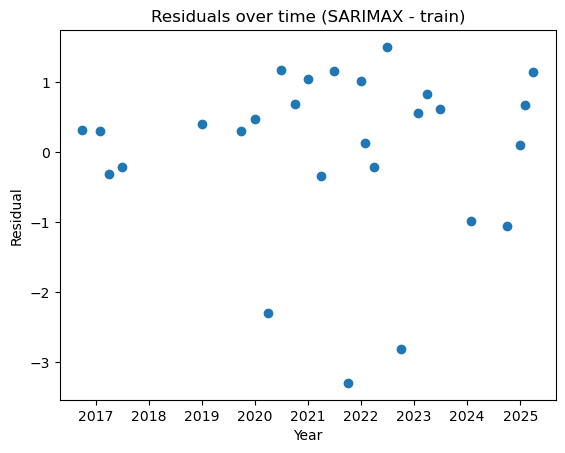

In [76]:
import matplotlib.pyplot as plt

train_residuals = train_targets_filings[loss_dates] - train_preds_filings

plt.scatter(loss_dates, train_residuals)
plt.title("Residuals over time (SARIMAX - train)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

Residuals are not quite normally distributed.

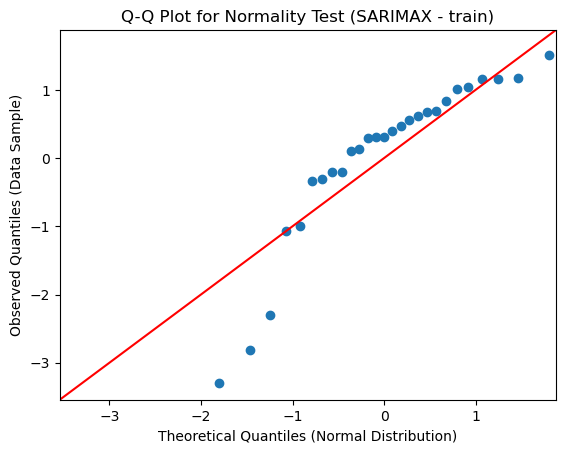

In [77]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.qqplot(train_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (SARIMAX - train)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

In [78]:
test_preds = pd.Series(model.predict(start=0, end=X_test.shape[0]-1, exog=scaler.transform(X_test)))
test_preds.index = X_test.index

In [79]:
loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(test_preds.index)))
test_preds_filings = test_preds[loss_dates]
test_targets_filings = y_test[loss_dates]
test_loss = rmse(test_preds_filings, test_targets_filings)

print(f"Test RMSE = {test_loss:.4f}")

Test RMSE = 1.0691


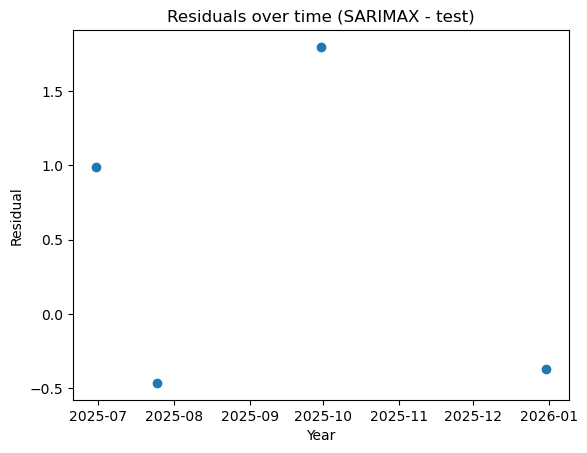

In [80]:
test_residuals = test_targets_filings[loss_dates] - test_preds_filings

plt.scatter(loss_dates, test_residuals)
plt.title("Residuals over time (SARIMAX - test)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

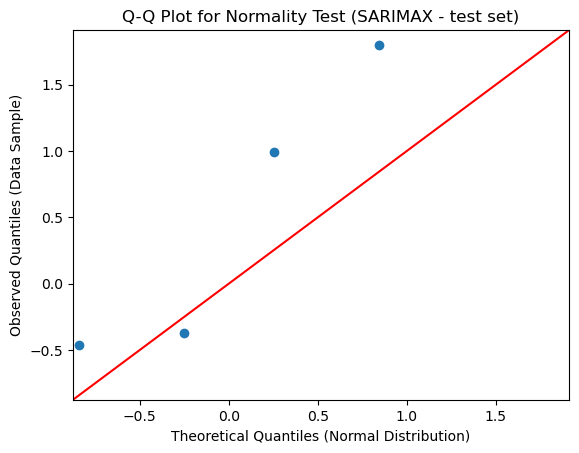

In [81]:
sm.qqplot(test_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (SARIMAX - test set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

# XGBoost Tree

In [82]:
!pip install xgboost

In [ ]:
import xgboost as xgb

In [84]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    objective='reg:squarederror',
    importance_type='gain' 
)

# Fit the model
model.fit(
    X_train.iloc[:-180], y_train.iloc[:-180],
    eval_set=[(X_test.iloc[:-180], y_test.iloc[:-180])],
    verbose=False
)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [85]:
train_preds = pd.Series(model.predict(X_train))
train_preds.index = X_train.index
train_preds.head(3)

Date
2016-09-30    0.015603
2016-10-03    0.015603
2016-10-04    0.015603
dtype: float32

In [86]:
loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(train_preds.index)))
train_preds_filings = train_preds[loss_dates]
train_targets_filings = y_train[loss_dates]
train_loss = rmse(train_preds_filings, train_targets_filings)

print(f"Train (including validation set) RMSE = {train_loss:.4f}")

Train (including validation set) RMSE = 1.1846


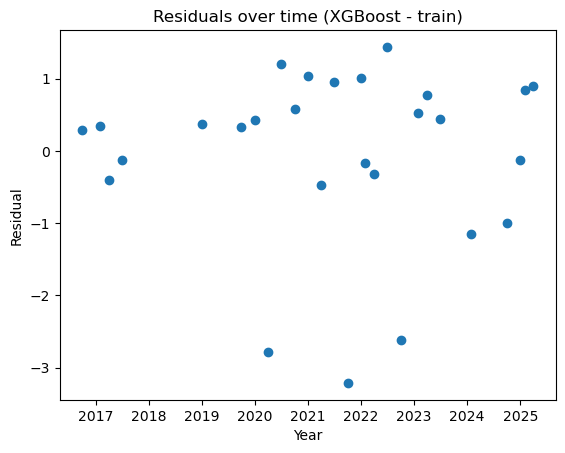

In [87]:
train_residuals = train_targets_filings[loss_dates] - train_preds_filings

plt.scatter(loss_dates, train_residuals)
plt.title("Residuals over time (XGBoost - train)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

Residuals are not normal. Likely overfitting

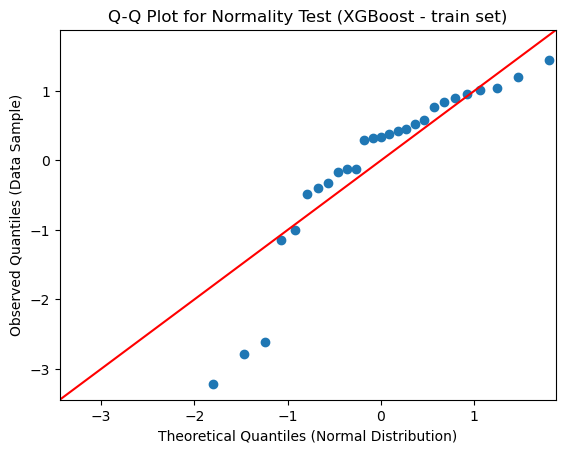

In [88]:
sm.qqplot(train_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (XGBoost - train set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

In [89]:
test_preds = pd.Series(model.predict(X_test))
test_preds.index = X_test.index
test_preds.head(3)

Date
2025-04-15    0.015603
2025-04-16    0.015603
2025-04-17    0.015603
dtype: float32

In [90]:
loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(test_preds.index)))
test_preds_filings = test_preds[loss_dates]
test_targets_filings = y_test[loss_dates]
test_loss = rmse(test_preds_filings, test_targets_filings)

print(f"Test RMSE = {test_loss:.4f}")

Test RMSE = 1.0887


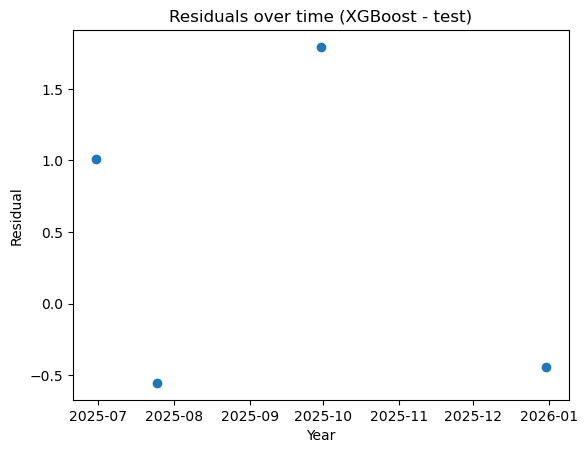

In [91]:
test_residuals = test_targets_filings[loss_dates] - test_preds_filings

plt.scatter(loss_dates, test_residuals)
plt.title("Residuals over time (XGBoost - test)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

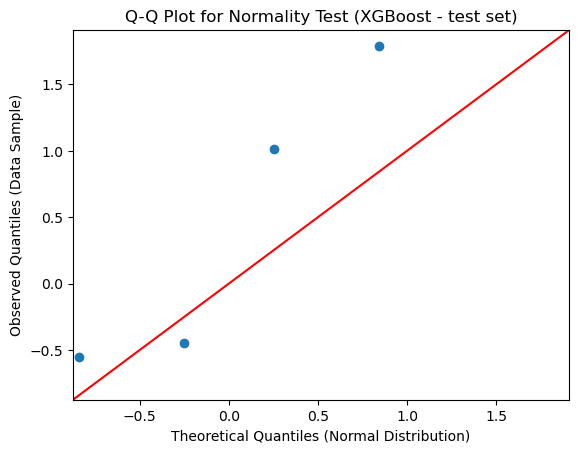

In [92]:
sm.qqplot(test_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (XGBoost - test set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

Note that price lags were not included because they overfit the tree structure.

# SARIMAX - Price Signals

In [93]:
prices = pd.read_csv(Path("preprocessed") / "KMB_prices_dates.csv")
print(prices.shape)
print(prices.isna().sum().sum())
prices.head(3)

(6282, 6)
0


,Date,Close,High,Low,Open,Volume
0,2001-02-22,28.992308,29.378873,28.784478,28.909178,1647106
1,2001-02-23,29.033878,29.137793,28.597437,29.096230,1784990
2,2001-02-26,29.125311,29.245853,28.406219,28.867603,1821287


In [94]:
y = prices["Close"] - prices["Open"]
X = prices[["Date", "Open"]].set_index("Date")

X.shape, y.shape

((6282, 1), (6282,))

In [95]:
!pip install pmdarima

In [96]:
X.index = pd.to_datetime(X.index)
y.index = X.index

# Use business day frequency and ffill holidays.
# Possible source of bias.
X = X.asfreq("B").ffill()
y = y.asfreq("B").ffill()

X_train, X_val, X_test= X.iloc[:-360], X.iloc[-360:-180], X.iloc[-180:]
y_train, y_val, y_test = y.iloc[:-360], y.iloc[-360:-180], y.iloc[-180:]

X_train.shape, y_val.shape, y_train.shape, X_test.shape, y_val.shape, y_test.shape

((6157, 1), (180,), (6157,), (180, 1), (180,), (180,))

In [97]:
import pmdarima as pm

loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(X_train.index)))
# SARIMAX tuning
model = pm.auto_arima(
    # Interpolate holidays (e.g. Jimmy Carter memoriam on 1.9.2025)
    # Source of bias as nans should be ignored in practice.
    y=y_train, 
    exogenous=X_train,  
    d=0,
    seasonal=True, m=5, 
    start_p=0, max_p=1, # autoregress 2-3 weeks before earnings
    start_q=0, max_q=1, # MA 2-3 weeks before earnings
    test='kpss',   
    stepwise=True, 
    out_of_sample_size=180, # forecast next 6 months
    scoring='mse',
    n_jobs=-1
    
)

print(model.summary())

c:\Users\seani\miniforge3\envs\kmb_analysis\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6157
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -7220.965
Date:                Mon, 16 Feb 2026   AIC                          14447.929
Time:                        15:51:33   BIC                          14468.105
Sample:                             0   HQIC                         14454.927
                               - 6157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0168      0.010      1.643      0.100      -0.003       0.037
ma.L1          0.0233      0.005      4.804      0.000       0.014       0.033
sigma2         0.6112      0.004    155.614      0.0

In [98]:
train_preds = model.predict(start = 0, end = X_train.shape[0]-1, exog = X_train, n_periods = 180)
train_preds = pd.Series(train_preds)
train_preds.index = y_val.index

train_preds.shape

(180,)

In [99]:
loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(train_preds.index)))
train_preds_filings = train_preds[loss_dates]
train_targets_filings = y_val[loss_dates]
train_loss = rmse(train_preds_filings, train_targets_filings)

print(f"Train RMSE = {train_loss:.4f}")

Train RMSE = 0.7971


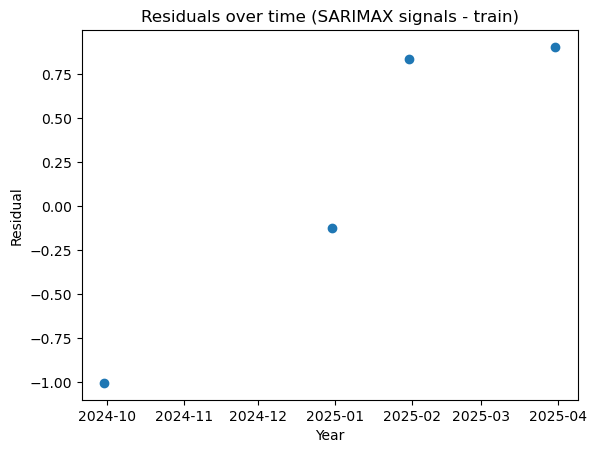

In [100]:
train_residuals = train_targets_filings - train_preds_filings

plt.scatter(loss_dates, train_residuals)
plt.title("Residuals over time (SARIMAX signals - train)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

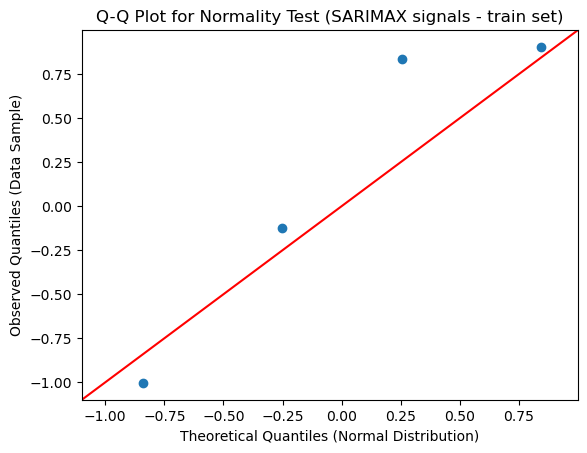

In [101]:
sm.qqplot(train_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (SARIMAX signals - train set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()

In [102]:
test_preds = model.predict(start = 0, end = X_val.shape[0]-1, exog = X_val, n_periods = 180)
test_preds = pd.Series(test_preds)
test_preds.index = y_test.index

test_preds.shape

(180,)

In [103]:
loss_dates = list(set(pd.DatetimeIndex(df_consolidated.index)).intersection(set(test_preds.index)))
test_preds_filings = test_preds[loss_dates]
test_targets_filings = y_test[loss_dates]
test_loss = rmse(test_preds_filings, test_targets_filings)

print(f"Test RMSE = {test_loss:.4f}")

Test RMSE = 1.0883


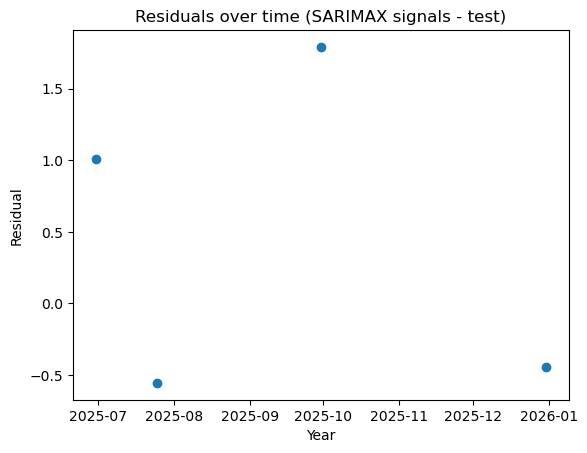

In [104]:
test_residuals = test_targets_filings[loss_dates] - test_preds_filings

plt.scatter(loss_dates, test_residuals)
plt.title("Residuals over time (SARIMAX signals - test)")
plt.xlabel("Year")
plt.ylabel("Residual")
plt.show()

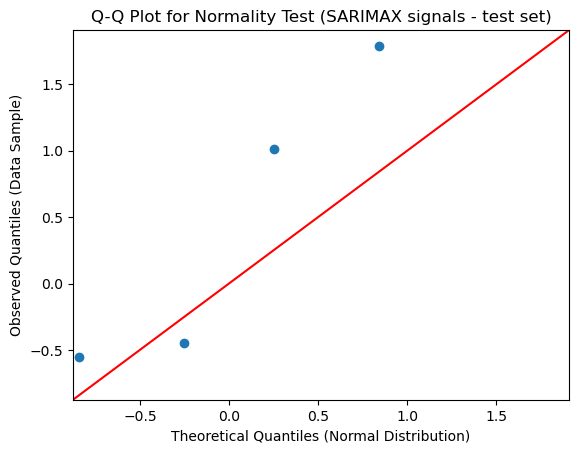

In [105]:
sm.qqplot(test_residuals, line='45')

# 3. Add labels and show the plot
plt.title('Q-Q Plot for Normality Test (SARIMAX signals - test set)')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Observed Quantiles (Data Sample)')
plt.show()